##### Social Media Analytics
### Introduction to Text Mining
## Frequency Analysis
(c) Nuno Antonio 2019-2022 v1.02

### Initial setup

In [1]:
# Import packages
import csv
import re

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
ds = pd.read_parquet("sputnikSentimentComplete.parquet.snappy", engine="fastparquet")

In [3]:
ds["date"] = pd.to_datetime(ds["date"], format="%d/%m/%y")

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 0 to 2159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   link                1615 non-null   object        
 1   Sentiment_Comments  600 non-null    float64       
 2   Polarity_Comments   600 non-null    category      
 3   title               1615 non-null   object        
 4   author              1615 non-null   object        
 5   date                1615 non-null   datetime64[ns]
 6   text                1615 non-null   object        
 7   comments            1615 non-null   object        
 8   Sentiment_Articles  1615 non-null   float64       
 9   Polarity_Articles   1615 non-null   category      
dtypes: category(2), datetime64[ns](1), float64(2), object(5)
memory usage: 116.8+ KB


### Functions

In [5]:
# Text preprocessing
def textPreProcess(
    rawText,
    removeHTML=True,
    charsToRemove=r"\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-| u |\'s|\/\/t|\[|\]|\*",
    removeNumbers=True,
    removeLineBreaks=False,
    specialCharsToRemove=r"[^\x00-\xfd]",
    convertToLower=True,
    removeConsecutiveSpaces=True,
):
    if type(rawText) != str:
        return rawText
    procText = rawText

    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText, "html.parser").get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove) > 0:
        procText = re.sub(charsToRemove, " ", procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r"\d+", " ", procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace("\n", " ").replace("\r", "")

    # Remove special characters
    if len(specialCharsToRemove) > 0:
        procText = re.sub(specialCharsToRemove, " ", procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower()

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(" +", " ", procText)

    return procText

In [6]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ""):
        return np.nan
    else:
        return word_tokenize(words)

In [7]:
# Stemm texts
def stemming(words):
    stemmed_word = [snowball.stem(x) for x in (words[:])]
    return stemmed_word

In [8]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1):
    vec = CountVectorizer(
        max_df=0.8,
        stop_words=stop_words,
        ngram_range=(nGrams, nGrams),
        max_features=10000,
    ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

### Analysis

In [9]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(
    data=ds.text.apply(textPreProcess).values,
    index=ds.index,
    columns=["PreProcessedText"],
)

In [10]:
# Tokenize text
processedReviews["Words"] = processedReviews["PreProcessedText"].apply(tokenize_words)

In [11]:
# Compute terms frequency distribution
from nltk.probability import FreqDist

fdist = FreqDist()
for review in processedReviews.Words:
    for term in review:
        fdist[term] += 1

In [12]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient="index")
df_fdist.columns = ["Frequency"]
df_fdist.index.name = "Term"
df_fdist = df_fdist.sort_values(by="Frequency", ascending=False)

In [13]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
the,43605
of,18681
to,18437
and,15816
in,14187
a,9848
that,9257
ukraine,6497
on,6372


In [14]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
divorce,1
malotaranovka,1
arc,1
inexpensive,1
proclivity,1
tragically,1
befallen,1
debacle,1
denigrate,1


In [15]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
stop_words.update(
    [
        "vladimir",
        "volodymyr",
        "said",
        "also",
        "would",
        "according",
        "follow",
        "sputnik",
        "live",
        "feed",
        "stay",
        "touch",
        "matter",
        "latest",
        "news",
        "https",
        "channels",
        "sputniknewsussputnik",
        "sputniknewsindia",
        "updates",
        "sputniknewsus",
    ]
)
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
ukraine,6497
russian,4965
russia,4473
ukrainian,4091
military,3758
us,2741
kiev,2256
operation,2177
forces,1885


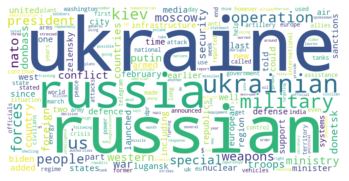

In [16]:
# Create a Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800, height=400, background_color="white", contour_color="white"
)
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word cloud shows some words have the same origin, such as "quarto" and "quartos". Let's create a stemmed version of the word cloud

In [17]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [18]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [19]:
# Do stemming
snowball = SnowballStemmer("english")
# Create a new column for stemm words
processedReviews["StemmedWords"] = processedReviews["Words"].apply(stemming)

In [20]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
    for term in review:
        fdist[term] += 1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient="index")
df_fdist.columns = ["Frequency"]
df_fdist.index.name = "Term"
df_fdist = df_fdist.sort_values(by="Frequency", ascending=False)

In [21]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]

In [22]:
df_fdist.head()

,Frequency
Term,
ukrain,6501
russian,5138
russia,4474
ukrainian,4367
militari,3771


In [23]:
processedReviews["PreProcessedText"].head()

index
0    the russian ministry of defense mod has releas...
1     over the past day the aviation carried out si...
3     as a result of a strike on an echelon at a ra...
5    the armed forces of ukraine failed in its effo...
7     over the past hours over ukrainian servicepeo...
Name: PreProcessedText, dtype: object

(-0.5, 799.5, 399.5, -0.5)

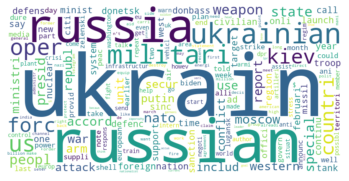

In [24]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(
    width=800, height=400, background_color="white", contour_color="white"
)
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [25]:
type(processedReviews["PreProcessedText"])

pandas.core.series.Series

In [26]:
stopwords.extend?

Object `stopwords.extend` not found.


The word cloud is now different. For example, "Quart" (room) is now more frequent than "hotel".

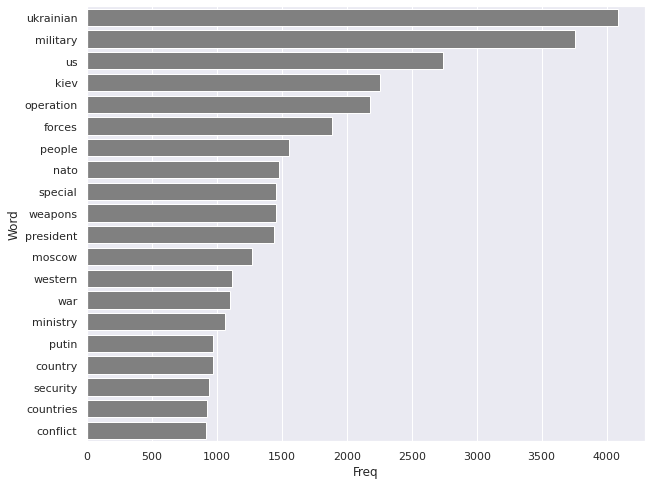

In [27]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

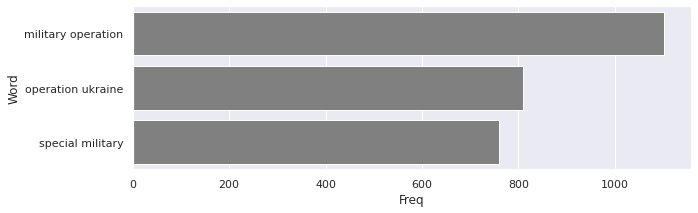

In [40]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=3, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 3)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

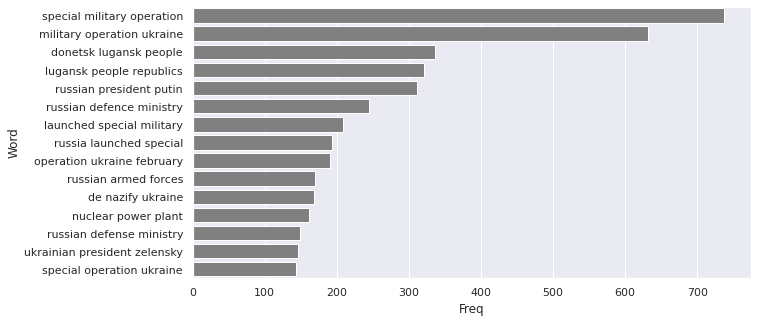

In [42]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=15, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 5)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

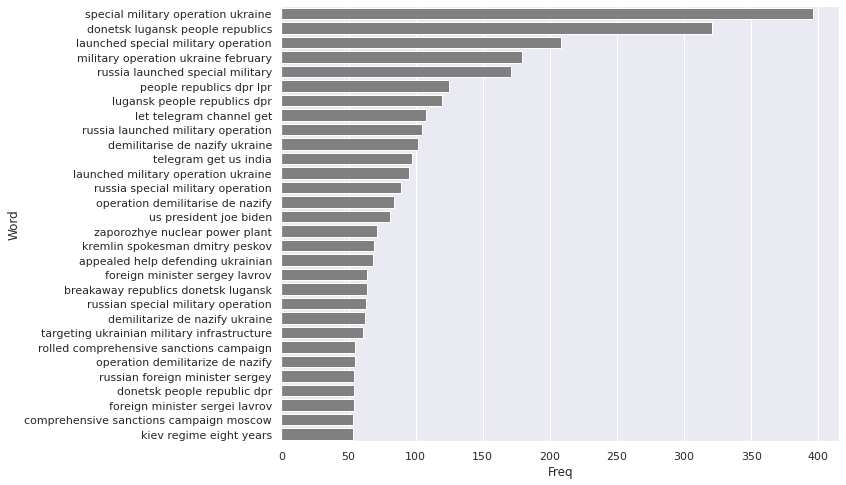

In [30]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=30, nGrams=4)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

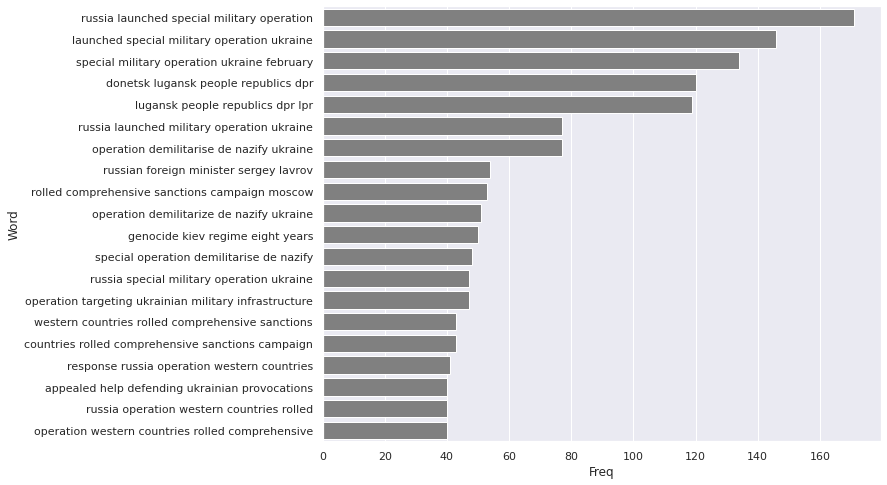

In [31]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=20, nGrams=5)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

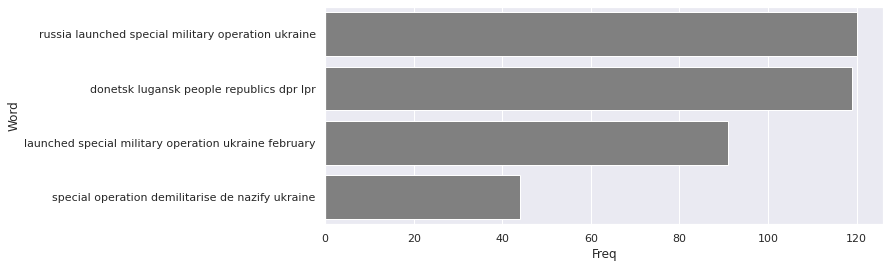

In [43]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=4, nGrams=6)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 4)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")